<a href="https://colab.research.google.com/github/flistz/DASC-5420/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier


# Data Loading

In [4]:
covertype = fetch_ucirepo(id=31)

X = covertype.data.features
y = covertype.data.targets

In [5]:
X.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,0
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,0
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,0
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,0
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,0


In [6]:
y.head(), y.Cover_Type.unique()

(   Cover_Type
 0           5
 1           5
 2           2
 3           2
 4           5,
 array([5, 2, 1, 7, 3, 6, 4]))

In [7]:
X.shape, y.shape

((581012, 54), (581012, 1))

In [8]:
y.Cover_Type.value_counts()

Cover_Type
2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: count, dtype: int64

# Data Preprocessing

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.to_numpy().reshape(-1, 1))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.1, random_state=111, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.22, random_state=111, stratify=y_train_val  # 0.22 x 0.9 = 0.198
)

Using cpu device


In [ ]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [ ]:
X_scaled[10]

array([-1.24065907e+00,  4.05162398e-01, -1.34927697e+00, -4.20741307e-01,
        7.85853051e-02, -1.03584605e+00,  2.18676905e-01,  9.95579045e-01,
        4.82612158e-01,  3.20323801e+00,  1.10807983e+00, -7.24162759e-02,
       -1.14549042e-01, -9.14905313e-02, -1.47649250e-01, -5.24997930e-02,
       -1.06985932e-01, -1.34443975e-02, -1.75550016e-02, -4.44752360e-02,
       -2.43946810e-01, -1.47734423e-01, -2.33216171e-01, -1.75866443e-01,
       -3.21251264e-02, -2.27231846e-03, -7.01478695e-02, -7.69715390e-02,
        1.74630129e+01, -8.34800147e-02, -1.27255868e-01, -3.80051874e-02,
       -2.46859838e-01, -3.32219214e-01, -1.94973038e-01, -2.85741845e-02,
       -6.69026389e-02, -4.32741576e-02, -4.03837703e-02, -4.97429330e-01,
       -2.34031401e-01, -2.14979610e-01, -3.15238030e-01, -2.90284104e-01,
       -5.27300460e-02, -5.71427461e-02, -1.43128266e-02, -2.26530657e-02,
       -1.65956116e-01, -1.56013984e-01, -1.23653545e-01, -2.32859052e-01,
       -8.79364021e-01, -

# Logistic regression

In [ ]:
y_train_labels = np.argmax(y_train_val, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

pca = PCA(n_components=0.95)  # Keep 95% of the variance
log_reg = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, tol=10)

pipeline = Pipeline(steps=[('pca', pca), ('logistic_regression', log_reg)])

param_grid = {
    'pca__n_components': [0.95],
    'logistic_regression__C': [0.1, 10],
    'logistic_regression__penalty': ['l2']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_val, y_train_labels)

print(f"Best parameters: {grid_search.best_params_}")

y_pred = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test_labels, y_pred)
print(f'Test Accuracy of Logistic Regression model after PCA: {test_accuracy * 100:.2f}%')

class_report = classification_report(y_test_labels, y_pred)
print("\nTest Classification Report after PCA:\n", class_report)

Best parameters: {'logistic_regression__C': 10, 'logistic_regression__penalty': 'l2', 'pca__n_components': 0.95}
Test Accuracy of Logistic Regression model after PCA: 72.22%

Test Classification Report after PCA:
               precision    recall  f1-score   support

           0       0.71      0.70      0.70     21184
           1       0.75      0.80      0.77     28331
           2       0.68      0.81      0.74      3575
           3       0.62      0.45      0.52       275
           4       0.26      0.01      0.01       949
           5       0.48      0.23      0.31      1737
           6       0.73      0.56      0.64      2051

    accuracy                           0.72     58102
   macro avg       0.60      0.51      0.53     58102
weighted avg       0.71      0.72      0.71     58102



# KNN

In [ ]:
# Convert one-hot encoded target arrays back to label encoded form
y_train_labels = np.argmax(y_train_val, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Define the PCA and the KNN model
pca = PCA(n_components=0.95)  # Keep 95% of the variance
knn = KNeighborsClassifier()

# Create a pipeline that combines PCA and KNN
pipeline = Pipeline(steps=[('pca', pca), ('knn', knn)])

# Define a parameter grid to search for the best hyperparameters for KNN
param_grid = {
    'pca__n_components': [0.95],  # You can experiment with this value
    'knn__n_neighbors': [3, 5, 7]  # Example values, adjust based on your dataset
}

# Initialize GridSearchCV if you want to perform hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with the grid search
grid_search.fit(X_train_val, y_train_labels)

# The best hyperparameters from the grid search
print(f"Best parameters: {grid_search.best_params_}")

# Predict labels for the test set
y_pred = grid_search.predict(X_test)

# Calculate the accuracy
test_accuracy = accuracy_score(y_test_labels, y_pred)

# Display the classification report
class_report = classification_report(y_test_labels, y_pred)

print(f'Test Accuracy of KNN model after PCA: {test_accuracy * 100:.2f}%')
print("\nTest Classification Report after PCA:\n", class_report)


Best parameters: {'knn__n_neighbors': 3, 'pca__n_components': 0.95}
Test Accuracy of KNN model after PCA: 92.16%

Test Classification Report after PCA:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92     21184
           1       0.93      0.94      0.93     28331
           2       0.90      0.90      0.90      3575
           3       0.86      0.78      0.82       275
           4       0.82      0.75      0.78       949
           5       0.81      0.79      0.80      1737
           6       0.94      0.93      0.94      2051

    accuracy                           0.92     58102
   macro avg       0.88      0.86      0.87     58102
weighted avg       0.92      0.92      0.92     58102



# Neural Network

## Building the Neural Network

In [ ]:
X_train_tensor = torch.tensor(X_train.astype(np.float32)).to(device)
y_train_tensor = torch.tensor(y_train.astype(np.float32)).to(device)
X_val_tensor = torch.tensor(X_val.astype(np.float32)).to(device)
y_val_tensor = torch.tensor(y_val.astype(np.float32)).to(device)
X_test_tensor = torch.tensor(X_test.astype(np.float32)).to(device)
y_test_tensor = torch.tensor(y_test.astype(np.float32)).to(device)

batch_size = 128

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(54, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 7)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net().to(device)

## Training the Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1)
criterion = nn.CrossEntropyLoss()

epochs = 1000
training_losses = []
validation_losses = []

for epoch in tqdm.tqdm(range(epochs), desc="Training", total=epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, torch.max(y_batch, 1)[1])
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    training_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, torch.max(y_val, 1)[1])
            val_loss += loss.item() * X_val.size(0)

    val_loss = val_loss / len(val_loader.dataset)
    validation_losses.append(val_loss)

    print(f'Epoch {epoch+1}: Training Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}')

    scheduler.step(val_loss)

Training:   0%|          | 1/1000 [00:10<2:56:11, 10.58s/it]

Epoch 1: Training Loss: 0.654474, Validation Loss: 0.551698


Training:  10%|█         | 100/1000 [16:50<2:30:48, 10.05s/it]

Epoch 100: Training Loss: 0.414352, Validation Loss: 0.333842


Training:  20%|█▉        | 195/1000 [32:30<2:12:30,  9.88s/it]

Epoch 195: Training Loss: 0.387861, Validation Loss: 0.311038


Training:  30%|██▉       | 296/1000 [49:20<1:57:32, 10.02s/it]

Epoch 296: Training Loss: 0.383091, Validation Loss: 0.308162


Training:  40%|███▉      | 397/1000 [1:06:19<1:39:30,  9.90s/it]

Epoch 397: Training Loss: 0.384878, Validation Loss: 0.308158


Training:  50%|████▉     | 497/1000 [1:22:57<1:24:19, 10.06s/it]

Epoch 497: Training Loss: 0.387017, Validation Loss: 0.308158


Training:  60%|█████▉    | 599/1000 [1:40:09<1:08:19, 10.22s/it]

Epoch 599: Training Loss: 0.383321, Validation Loss: 0.308158


Epoch 694: Training Loss: 0.383223, Validation Loss: 0.308157


Training:  70%|██████▉   | 695/1000 [1:56:17<51:57, 10.22s/it]

Training:  80%|████████  | 800/1000 [2:13:59<32:54,  9.87s/it]

Epoch 800: Training Loss: 0.382931, Validation Loss: 0.308157


Training:  90%|█████████ | 900/1000 [2:31:05<17:56, 10.76s/it]

Epoch 900: Training Loss: 0.382417, Validation Loss: 0.308158


Epoch 975: Training Loss: 0.382890, Validation Loss: 0.308157


Training:  98%|█████████▊| 976/1000 [2:44:29<04:04, 10.17s/it]

Epoch 976: Training Loss: 0.382487, Validation Loss: 0.308157


## Plotting the Loss

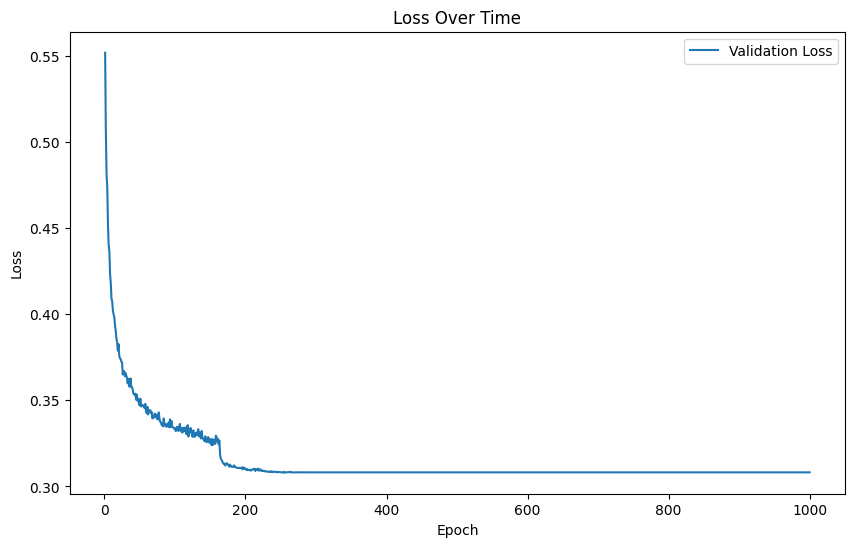

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()

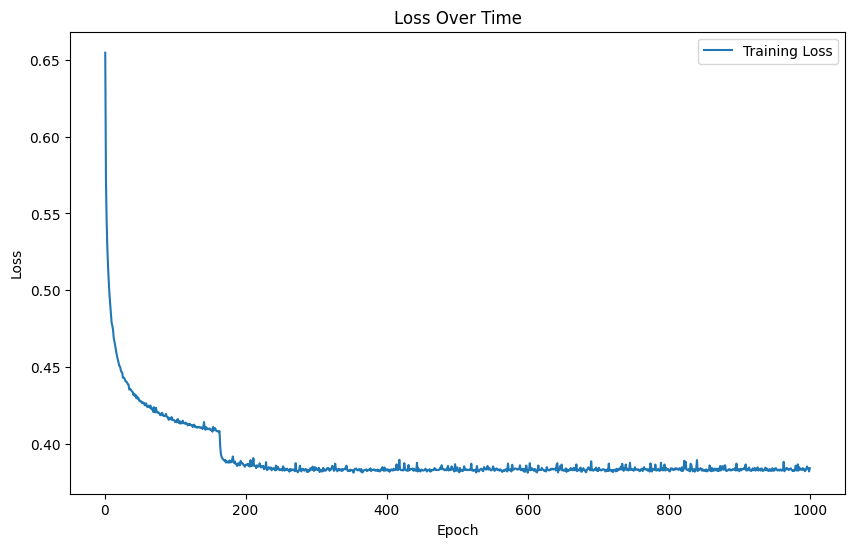

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()

## Evaluation on Test Dataset

In [ ]:
model.eval()

true_labels = []
pred_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)

        true_labels.append(y_batch.cpu().numpy())
        pred_labels.append(preds.cpu().numpy())

true_labels = np.concatenate(true_labels)
pred_labels = np.concatenate(pred_labels)

true_labels = np.argmax(true_labels, axis=1)

In [ ]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86     21184
           1       0.87      0.92      0.89     28331
           2       0.83      0.91      0.87      3575
           3       0.86      0.76      0.80       275
           4       0.83      0.60      0.70       949
           5       0.80      0.67      0.73      1737
           6       0.92      0.87      0.89      2051

    accuracy                           0.87     58102
   macro avg       0.86      0.79      0.82     58102
weighted avg       0.87      0.87      0.87     58102

